In [13]:
import torch
print(torch.__version__)
print(torch.version.cuda)
!nvcc --version

1.11.0+cu113
11.3
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
python main.py --data_dir data/multi_part/fridge_10489 --cfg_dir config/release/ --num_parts 3 --save_dir runs/pretrained_multi_part_fridge_10489 --ckpt_path runs/pretrained_ckpts/pretrained_multi_part_fridge_10489/ckpt/model_latest.pth --test_only
python main.py --data_dir data/paris/scissor_11100 --cfg_dir config/release/ --num_parts 2 --save_dir runs/pretrained_paris_scissors_11100 --ckpt_path runs/pretrained_ckpts/pretrained_paris_scissor_11100/ckpt/model_latest.pth --test_only  
python main.py --data_dir data/paris/stapler_103111 --cfg_dir config/release/ --num_parts 2 --save_dir runs/pretrained_paris_stapler_103111 --ckpt_path runs/pretrained_ckpts/pretrained_paris_scissor_11100/ckpt/model_latest.pth --test_only  
python main.py --data_dir data/paris/knife_101217 --cfg_dir config/release/ --num_parts 2 --save_dir runs/paris_knife --ckpt_path runs/pretrained_ckpts/pretrained_paris_scissor_11100/ckpt/model_latest.pth --test_only  
python main.py --data_dir data/paris/blade_103706/ --cfg_dir config/release/ --num_parts 2 --save_dir runs/pretrained_paris_blade_103706 --ckpt_path runs/pretrained_ckpts/pretrained_paris_blade_103706/ckpt/model_latest.pth --test_only  

# Eval
python eval/eval_results.py --gt_path data/paris/scissor_11100/gt --pred_path runs/pretrained_paris_scissors_11100/results/step_0004000
python eval/eval_mesh.py --gt_folder data/paris/scissor_11100/gt --gt_s data/paris/blade_103706/gt/start/start_static_rotate.ply --gt_d data/paris/blade_103706/gt/start/start_dynamic_rotate.ply --gt_w data/paris/blade_103706/gt/start/start_rotate.ply --pred_folder runs/pretrained_paris_scissors_11100/results/step_0004000 --pred_s runs/pretrained_paris_scissors_11100/results/step_0004000/init_part_0.obj --pred_d runs/pretrained_paris_scissors_11100/results/step_0004000/init_part_1.obj --pred_w runs/pretrained_paris_scissors_11100/results/step_0004000/init_all.obj 

# Generate LOFTR Correspondences (if correspondence runs out of memory either use compression to reduce file size or reduce batch size)
python gen_correspondence.py --data_path ../data/paris/knife_101217_train_set/ --output_path ../data/paris/knife_101217_train_set/correspondence_loftr  --top_k=30
python gen_correspondence.py --data_path ../data/paris/USB_100109/ --output_path ../data/paris/USB_100109/correspondence_loftr2  --top_k=30


# Train 
python main.py --data_dir data/paris/knife_101217_train_set/ --cfg_dir config/release/ --num_parts 2 --save_dir runs/knife_101217_train_set
python main.py --data_dir data/paris/USB_100109 --cfg_dir config/release/ --num_parts 2 --save_dir runs/partnet_USB_100109_train

SyntaxError: invalid syntax (2747180621.py, line 1)

# Preprocessing Data
* Mask
* GT
* Color
* Depth 
* LoFTR

* Keyframes is the cam object in the camera.json file

# Compute Depth

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the image is grayscale)
image = cv2.imread('./data/paris/knife_101217/mask/00000_000.png', cv2.IMREAD_UNCHANGED)

# Check if image was loaded successfully
if image is None:
    raise ValueError("Image not loaded properly. Check the path.")

print(image.min(), image.max())
# Normalize the image to the range [0, 1]
# The object has pixel values between 0 and 255 (grayscale), so we scale it
# No need to invert here, just normalize as is
# normalized_depth = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# # Invert the normalized values so black (0) becomes 1 and white (1) becomes 0
# inverted_depth = .8 (1 - normalized_depth)
# # Save or display the resulting depth map
# plt.imshow(inverted_depth, cmap='gray')
# plt.colorbar(label='Depth Scale')
# plt.title('Depth Map')
# plt.show()

# Save the depth map (optional)
# cv2.imwrite('depth_map.png', (inverted_depth * 255).astype(np.uint8))  # Scaled back to 0-255 for saving


0 255


# Make cam_k.txt and init_keyframes.yml

In [ ]:
import json
import numpy as np
import yaml

# The provided JSON camera_train data
camera_train_json = '''
{
    "K": [[1111.111111111111, 0, 400.0], [0.0, 1111.111111111111, 400.0], [0.0, 0.0, 1.0]],
    "0000": [[-0.25941553711891174, 0.83037269115448, -0.4931377172470093, -1.5780407190322876], [-0.9657658338546753, -0.2230474203824997, 0.13246232271194458, 0.4238794445991516], [0.0, 0.5106183886528015, 0.8598074913024902, 2.7513840198516846], [0.0, 0.0, 0.0, 1.0]],
    "0001": [[-0.8676013946533203, -0.29778850078582764, 0.3982335031032562, 1.274347186088562], [0.4972604215145111, -0.5195702314376831, 0.6948229074478149, 2.223433256149292], [0.0, 0.8008551001548767, 0.5988582372665405, 1.9163464307785034], [0.0, 0.0, 0.0, 1.0]],
    "0002": [[0.45632070302963257, 0.4698680639266968, -0.7556424140930176, -2.418055772781372], [-0.8898155093193054, 0.24096064269542694, -0.3875132203102112, -1.2400423288345337], [-1.4901162970204496e-08, 0.8492125868797302, 0.5280511379241943, 1.6897636651992798], [0.0, 0.0, 0.0, 1.0]],
    "0003": [[0.9980420470237732, -0.03329584747552872, 0.0529484786093235, 0.16943512856960297], [0.0625472217798233, 0.5312891006469727, -0.8448785543441772, -2.703611373901367], [-3.725290298461914e-09, 0.8465360999107361, 0.5323313474655151, 1.7034603357315063], [0.0, 0.0, 0.0, 1.0]]
}
'''

# Convert the JSON string to a Python dictionary
camera_train = json.loads(camera_train_json)

# Prepare the dictionary to store data in YAML format
yaml_data = {}

# First, handle the intrinsic matrix "K"
yaml_data['intrinsic'] = {'K': camera_train['K']}

# Now, handle the transformation matrices for each frame
yaml_data['keyframes'] = {}
for key in camera_train:
    if key != 'K':  # Skip 'K' because it's the intrinsic matrix
        yaml_data['keyframes'][key] = camera_train[key]

# Write the data to a YAML file
with open('init_keyframes.yml', 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False, sort_keys=False)

# Output success message
print("Data successfully written to init_keyframes.yml")


# Generate Masks

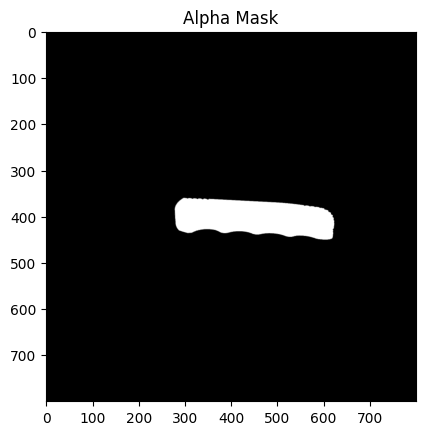

True

In [7]:
# Load the image with the alpha channel
image = cv2.imread('/media/qil/DATA/Carter_Articulated_Objects/NeuralImplicitRepresentation/data/multi_part/knife_101217/color_segmented/end/test/0002.png', cv2.IMREAD_UNCHANGED)

# Split the image into its components (R, G, B, and Alpha)
b, g, r, alpha = cv2.split(image)

# Use the alpha channel as the mask (non-transparent areas will be 1, transparent will be 0)
mask = alpha

# Display the mask
plt.imshow(mask, cmap='gray')
plt.title('Alpha Mask')
plt.show()

# Save the mask (optional)
cv2.imwrite('alpha_mask.png', mask)


# Color Segmented Images 


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


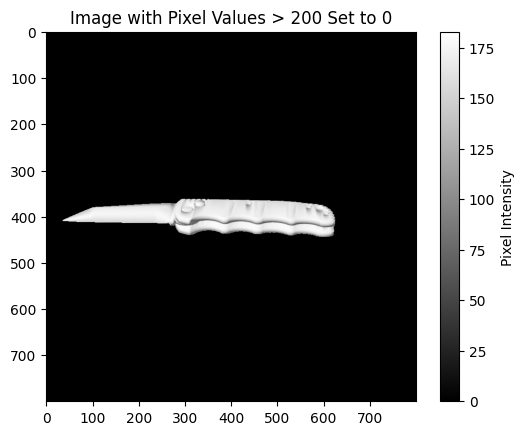

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (grayscale or depth map)
image = cv2.imread('/media/qil/DATA/Carter_Articulated_Objects/NeuralImplicitRepresentation/data/multi_part/knife_101217/color_segmented/start/test/0001.png', cv2.IMREAD_GRAYSCALE)

# Check if image is loaded properly
if image is None:
    raise ValueError("Image not loaded properly. Check the path.")

# Set all pixel values over 200 to 0
image[image > 200] = 0

# Print the modified image (to see the matrix, optional)
print(image)

# Display the resulting scaled image
plt.imshow(image, cmap='gray')
plt.title('Image with Pixel Values > 200 Set to 0')
plt.colorbar(label='Pixel Intensity')
plt.show()


# Convert to Key init frames 


In [ ]:
import json
import numpy as np

# Assuming the camera_train data is provided as a JSON string (or dictionary)
camera_train_json = './data/paris/knife_101217/camera_test.json'

# Convert the JSON string to a Python dictionary (skip this if it's already a dict)
camera_train = json.loads(camera_train_json)

# Function to convert the transformation matrices to numpy arrays
camera_train_np = {key: np.array(value) for key, value in camera_train.items()}

# Example: Access the intrinsic matrix 'K'
K_matrix = camera_train_np['K']
print("Intrinsic matrix K:", K_matrix)

# Example: Access a transformation matrix '0000'
T_matrix_0000 = camera_train_np['0000']
print("Transformation matrix 0000:", T_matrix_0000)


# Visualize Objects

In [1]:
import open3d as o3d

# Load the initial and final part OBJ files
init_part_0 = o3d.io.read_triangle_mesh("./runs/knife_101217/results/step_0004000/init_part_0.obj")
init_part_1 = o3d.io.read_triangle_mesh("./runs/knife_101217/results/step_0004000/init_part_1.obj")
last_part_0 = o3d.io.read_triangle_mesh("./runs/knife_101217/results/step_0004000/last_part_0.obj")
last_part_1 = o3d.io.read_triangle_mesh("./runs/knife_101217/results/step_0004000/last_part_1.obj")

# Load the predicted revolute axis
axis = o3d.io.read_triangle_mesh("./runs/knife_101217/results/step_0004000/init_axis_0_revolute.obj")

# Color the parts differently
init_part_0.paint_uniform_color([1, 0, 0])  # Red
init_part_1.paint_uniform_color([0, 1, 0])  # Green
last_part_0.paint_uniform_color([0, 0, 1])  # Blue
last_part_1.paint_uniform_color([1, 1, 0])  # Yellow
axis.paint_uniform_color([1, 0, 1])  # Magenta

# Visualize everything
o3d.visualization.draw_geometries([init_part_0, init_part_1, last_part_0, last_part_1, axis])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
